# هدف پروژه

## توضیح کلی پروژه و تعریف صورت مسئله:

در این پروژه قصد داریم با استفاده از Naive Bayes Classifier به تجزیه و تحلیل مقالات سایت دیجی‌کالا مگ و دسته‌بندی آنها بپردازیم و سعی کنیم با استفاده از داده‌هایی که درمورد توضیحات هر مقاله داریم، دسته‌بندی آن را پیش‌بینی کنیم.

In [1]:
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline 
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import pandas as pd
import numpy as np
import parsivar
import codecs
import time
import re

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.dropna(subset=['content'], inplace=True)
test.dropna(subset=['content'], inplace=True)
train.dropna(subset=['label'], inplace=True)
test.dropna(subset=['label'], inplace=True)

In [3]:
train.head()

,content,label
0,فیلم‌های در حال اکران؛ موزیکال شاد خاله قورباغ...,هنر و سینما
1,پنج فیلمسازی که کوئنتین تارانتینو را عاشق سینم...,هنر و سینما
2,جانی آیو از اپل رفت جانی آیو دیگر نیازی به معر...,علم و تکنولوژی
3,احتمال عدم پشتیبانی iOS ۱۳ از آیفون ۵ اس، SE و...,علم و تکنولوژی
4,دزدان مغازه نماینده ژاپن در اسکار ۲۰۱۹ شد فیلم...,هنر و سینما


In [4]:
train['label'].unique()

array(['هنر و سینما', 'علم و تکنولوژی', 'سلامت و زیبایی', 'بازی ویدیویی'],
      dtype=object)

همان طور که مشاهده می شود در هر داده، توضیحات مقاله و همینطور دسته بندی آن مشخص شده است. در این مجموعه داده ۴ دسته وجود دارند که به صورت زیر می‌باشند:
+  علم و تکنولوژی
+  هنر و سینما 
+  بازی ویدویی
+  سلامت و زیبایی

## فاز اول: پیش پردازش داده
### آشنایی با کتابخانه‌های هضم و پارسی ور
#### هضم
+ تمیز و مرتب کردن متن  
+ تقطیع جمله‌ها و واژه‌ها
 + Sentence Segmentation
 + Tokenization
+ ریشه‌یابی واژه‌ها
+ تحلیل صرفی جمله
+ تجزیه نحوی جمله
+ واسط استفاده از داده‌های زبان فارسی
+ سازگاری با بسته NLTK
+ پشتیبانی از پایتون نسخه 2 و 3


#### پارسی‌ور
+ تمیز و مرتب کردن متن  
+ تقطیع جمله‌ها و واژه‌ها
 + Sentence Segmentation
 + Tokenization
+ ریشه‌یابی واژه‌ها
+ تحلیل صرفی جمله
+ تجزیه نحوی جمله
+ قابلیت استخراج مقادیر تاریخی عددی از متن
+ تبدیل کلمات فینگلیش یا پینگلیش به فارسی

### مهمترین روش‌های پیش‌پردازش متن 
به ترتیب 
+  تبدیل متن به حروف کوچک
+  پاک کردن اعداد
+  پاک کردن علائم نقطه گذاری
+  پاک کردن فضا‌های خالی
+  توکن بندی کلمات
+  حذف کردن کلمات فاقد اهمیت کافی
+  ریشه‌یابی کلمات

####  نرمال سازی
در فرآیند نرمال‌سازی می‌خواهیم همه متون استاندارد و یکپارچه شوند. برای مثال تبدیل اعداد انگلیسی به فارسی حذف اسپیس‌ها و فضا‌های خالی اضافی  حذف تشدید از کلمات (چون تشدید مخصوص زبان عربی است) و موارد مختلفی دیگری که بسته به نیاز هر پروژه باید روی متن اعمال شود تا متون همه یک‌دست شوند.
در این پروژه از کتابحانه پارسی ور استفاده شده است برای نرمال‌سازی (استاندارد سازی) متن یک شی از کلاس Normalizer ساخته شده و پس از آن از متد normalizer از شی parsivar_normalizer استفاده شده است.

In [ ]:
def normalize(self):
    self.text = self.parsivar_normalizer.normalize(self.text)
    self.text = ''.join([i for i in self.text if not i.isdigit()])
    self.text = re.sub(r'\s*[A-Za-z]+\b', '', self.text)
    self.text = self.text.replace(u'\u200c', '#')

در متاد normalize علاوه بر فراخوانی متد کتابخانه پارسی‌ور، به کمک کد بالا ارقام و حروف انگلیسی از متن حذف شده و نیم‌فاصله به # تغییر پیدا کرده است تا در ادامه به کمک فراخوانی متاد remove_stop_words بهتر بتوان کلماتی مانند "بهره‌مند"، "فیلم‌های" و... را پردازش نمود. 

In [ ]:
 def remove_stop_words(self):
        words = []
        for word in self.word_list:
            if word in self.stop_words:
                continue
            if '#' in word:
                for w in word.split('#'):
                    if w in self.stop_words:
                        continue
                    words.append(w)
            else:
                words.append(word)
        self.word_list = words

#### توکن یابی (Tokenization)
به فرآیندی که طی آن جمله به یکسری واژه (توکن) تبدیل می‌شود. در parsivar برای استفاده از این قابلیت متاد Tokenize_Words از شی tokenizer فراخوانی شده است. خروجی شامل یکسری واژه است.

In [ ]:
def word_tokenize(self):
    self.word_list = self.tokenizer.tokenize_words(self.text)

### سوال 1
#### ریشه یابی (Stemming)
فرآیندی که طی آن ریشه یک واژه به دست می‌آید. مثل “کتاب‌ها” که دارای ریشه “کتاب” است یا “می‌خوردن” که دارای ریشه “خورد#خور” است. در فرآیند Stemming، برای بدست آوردن ریشه، یکسری گام‌ها به ترتیب انجام می‌شوند و در اصطلاح برای آن الگوریتم تعریف می‌شود برای مثال ابتدا پیشوند حذف شود. در گام بعدی به سراغ پسوندها می‌روند و گام‌های بعدی به همین صورت. ضعف جدی این روش گاهی تولید ریشه بی معنی است مثلا ریشه “بشارت دادم” که ممکن است “ب” به‌عنوان پیشوند در نظر گرفته و نتیجه غلط شود. برای زبان انگلیسی معمولا از الگوریتم porter استفاده می‌کنند ولی متاسفانه برای زبان فارسی الگوریتم قابل اعتمادی توسط زبان شناسان ارائه نشده است.

#### ریشه یابی (Lemmatization)
هر دوی Stemming و Lemmatization یک کار یکسان ولی به روش مختلف انجام می‌دهند. Lemmatization شبیه به این است که با دیدن یک کلمه، به سراغ دایره المعارف رفته و بررسی‌های لازم را انجام داده و یک کلمه را به عنوان ریشه برمی‌گرداند. مزیت این روش تولید نشدن کلمات نامربوط به عنوان ریشه است. البته سرعت این روش نسبت به Stemming پایین‌تر است چون باید جستجو انجام شود.
پارسی ور فقط از قابلیت Stemming پشتیبانی می‌کند. برای استفاده از این قابلیت ابتدا باید کلاس FindStems  قبل از استفاده import شود.

In [ ]:
def stem(self):
        self.word_list = [self.stemmer.convert_to_stem(word) for word in self.word_list]

#### stop-word
کلمات بدون استفاده (غیر مفید در حین پردازش) را «کلمات توقف» (Stop words) می‌گویند. از دیگر معادل‌هایی که در زبان فارسی برای کلمات توقف استفاده می‌شود، می‌توان به کلمات بازدارنده، کلمات ممنوعه و یا Stop Word اشاره کرد. برای استفاده از stop-word های زبان فارسی از فایل persian در کنار برنامه استفاده شده است و اطلاعات این فایل به کمک کد زیر در برنامه استفاده شده است.

In [ ]:
def create_stop_words(self, file_name):
        self.stop_words = sorted(list(set(
            [
                self.parsivar_normalizer.normalize(w) for w in codecs.open(file_name, encoding='utf-8').read().split('\n') if w
            ])))


In [5]:
LAST = -1
SMOOTH = 5
SELECTED_WORD = 75
STARS = ' ****** '
DASH = '-'
WRONGLY_COUNT = 5

PREPROCESS_AND_SMOOTH = 'Preprocessing & Smoothing'
JUST_PREPROCESS = 'Preprocessing'
JUST_SMOOTH = 'Smoothing'
NOTHING = 'Nothing'

In [6]:
def draw_histogram(dataset, title, column, color):
    plt.figure()
    plt.suptitle('Histogram of ' + column + ' in ' + title, fontsize = 15)
    plt.xlabel(column, fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)
    dataset['label'].apply(lambda x: get_display(reshape(x))).hist(color = color)

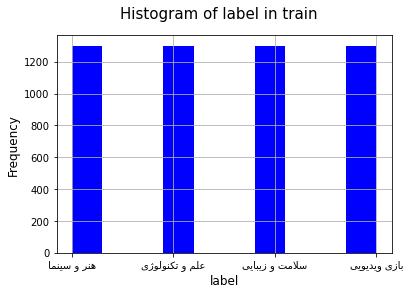

In [7]:
draw_histogram(train, 'train', 'label', 'blue')

با توجه به نمودار‌ بالا تعداد سطرها به ازای هر موضوع دسته‌بندی در دیتاست train به صورت متوازن قرار داده شده است و نیازی به یکسان کردن تعداد آگهی‌ها از دسته‌بندی‌های متفاوت که به نام resampling شناخته می‌شود نیست.

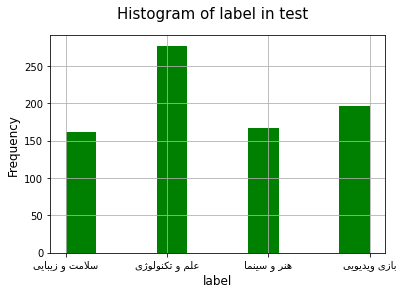

In [8]:
draw_histogram(test, 'test', 'label', 'green')

##  فاز دوم: فرآیند مسئله
در این مسئله از مدل words of bag استفاده شده است. به این صورت که هر کلمه را مستقل از جایگاه و ترتیب آن در جمله در نظر گرفته می شود. feature ها تعداد هر کلمه در کلاس می باشد. یعنی هر چه تعداد یک کلمه در یک کلاس بیشتر باشد، احتمال اینکه آن کلمه متعلق به آن کلاس باشد بیشتر است. برای حل این مسئله از bayes naive استفاده شده است.

![alt text](naive.png "Title")

### سوال 2
Posterior: پسین، احتمالی که پس از مشاهده‌ی شواهد (به عبارت ریاضی، به شرط شواهد) قرار است محاسبه شود.

Prior: پیشین، احتمالی که برای کلاس مربوطه بدون مشاهده ی شواهد محاسبه شده است.
در این مدل p(c) یا p(label) برابر است با نسبت تعداد مقاله‌های موجود از این دسته‌بندی به تعداد کل مقاله‌ها و p(x) یا p(word) برابر است با تعداد تکرار کلمه مورد نظر به روی تعداد کل کلمات.

Likelihood: در این مدل همان احتمال p(word|label) است که در محاسبه ی احتمال پسین کاربرد دارد. این احتمال به راحتی قابل محاسبه است. کافی است نسبت تعداد تکرار هر کلمه در هر کلاس را به مجموع تمامی کلمات آن کلاس به دست آورد.

Evidence: شواهد، شواهدی که مشاهده می‌شوند و بر احتمالی که قصد محاسبه‌ی آن است اثر می‌گذارند. در این مدل هر کلمه‌ای که در content مقاله دیده می‌شود، شواهد ما خواهد بود.

## Biagram
### سوال 3

1) پیچ فلزی را محکم کردم.
2) از پیچ جاده گذشتم.
در اینجا قرار گرفتن کلمه "پیچ" در کنار "فلزی" یا "جاده" می‌تواند به فهم درست معنای این کلمه کمک کند. در این مثال استفاده از bigrams به تنهایی کافی می‌باشد.

## Additive Smoothing
### سوال 4

در بخشی از محاسبه‌ی احتمال p(label|content)، مقادیر p(word|label) در هم ضرب می‌شوند. بنابراین اگر کلمه‌ای در کلاسی نباشد، مقدار p(word|label) صفر است که این امر موجب صفر شدن p(label|content) می‌شود که این امر خطای بالایی را به مدل ما تحمیل می‌کند.


### سوال 5 

برای حل این مشکل می‌توان از روش Additive Smoothing استفاده کرد. در این روش هنگام محاسبه‌ی p(word|label)، صورت کسر را با مقدار smooth و همچنین مخرج کسر را با مقدار smooth * k جمع کرده که k برابر با تعداد کل کلمات در content مورد نظر است. این کار موجب می‌شود هنگام ضرب مقادیر p(word|label) هیچ مقداری صفر نباشد.  
اگر مقدار smooth صفر باشد نتیجه همان حالت without additive smoothing خواهد شد. در این مدل مقدار smooth برابر 5 در نظر گرفته شده است.

In [9]:
class Preprocessor:
    def __init__(self):
        self.text = ''
        self.word_list = []
        self.stop_words = []
        self.parsivar_normalizer = parsivar.Normalizer()
        self.tokenizer = parsivar.Tokenizer()
        self.stemmer = parsivar.FindStems()
        self.create_stop_words('persian')

    def create_stop_words(self, file_name):
        self.stop_words = sorted(list(set(
            [
                self.parsivar_normalizer.normalize(w) for w in codecs.open(file_name, encoding='utf-8').read().split('\n') if w
            ])))

    def just_tokenize(self, text):
        return text.split()

    def normalize(self):
        self.text = self.parsivar_normalizer.normalize(self.text)
        self.text = ''.join([i for i in self.text if not i.isdigit()])
        self.text = re.sub(r'\s*[A-Za-z]+\b', '', self.text)
        self.text = self.text.replace(u'\u200c', '#')

    def stem(self):
        self.word_list = [self.stemmer.convert_to_stem(word) for word in self.word_list]

    def word_tokenize(self):
        self.word_list = self.tokenizer.tokenize_words(self.text)

    def remove_stop_words(self):
        words = []
        for word in self.word_list:
            if word in self.stop_words:
                continue
            if '#' in word:
                for w in word.split('#'):
                    if w in self.stop_words:
                        continue
                    words.append(w)
            else:
                words.append(word)
        self.word_list = words

    def run(self, text):

        self.text = text
        self.normalize()
        self.word_tokenize()
        self.remove_stop_words()
        self.stem()

        return self.word_list

In [10]:
class Classifier:
    def __init__(self):
        self.preprocessor = Preprocessor()
        self.smooth = SMOOTH
        self.confusion_matrix = np.array([])
        self.accuracies_none = []
        self.accuracies = []
        self.precisions = []
        self.recalls = []
        self.f1_scores = []
        self.modes = []
        self.wrongly_samples = []
        self.index = LAST
        self.five_words = {}
        self.labels = {'بازی ویدیویی' : 'video_games',
                       'سلامت و زیبایی' : 'health_and_beauty',
                       'علم و تکنولوژی' : 'science_and_technology',
                       'هنر و سینما' : 'art_and_cinema'
                       }

    def initialize(self, train, test, mode):
        self.modes.append(mode)
        self.mode = mode
        self.index = self.index + 1
        self.train = train.copy()
        self.test = test.copy()
        self.p_health_and_beauty = len(self.train[(self.train['label'] == 'سلامت و زیبایی')]. \
                                       index) / len(self.train.index)

        self.p_science_and_technology = len(self.train[(self.train['label'] == 'علم و تکنولوژی')]. \
                                            index) / len(self.train.index)

        self.p_art_and_cinema = len(self.train[(self.train['label'] == 'هنر و سینما')]. \
                                    index) / len(self.train.index)

        self.p_video_games = 1 - (self.p_health_and_beauty + self.p_science_and_technology + self.p_art_and_cinema)

        if mode == JUST_PREPROCESS:
            self.apply_preprocessing = True
            self.apply_smoothing = False

        elif mode == JUST_SMOOTH:
            self.apply_preprocessing = False
            self.apply_smoothing = True

        elif mode == PREPROCESS_AND_SMOOTH:
            self.apply_smoothing = True
            self.apply_preprocessing = True

        else:
            self.apply_smoothing = False
            self.apply_preprocessing = False

    def preprocess(self):
        self.train['content'] = self.train['content'].apply(self.preprocessor.run)
        self.test['content'] = self.test['content'].apply(self.preprocessor.run)

    def extract_words(self):
        data = self.train.copy()
        data = pd.DataFrame({'label': np.repeat(data['label'].values, data['content'].str.len())}).assign \
            (**{'content': np.concatenate(data['content'].values)})[data.columns.tolist()]

        data.columns = ['word', 'label']
        self.data_health_and_beauty = data[(data.label == 'سلامت و زیبایی')][['word']]
        self.data_science_and_technology = data[(data.label == 'علم و تکنولوژی')][['word']]
        self.data_art_and_cinema = data[(data.label == 'هنر و سینما')][['word']]
        self.data_video_games = data[(data.label == 'بازی ویدیویی')][['word']]

    def compute_frequencies(self):
        self.data_video_games['frequency'] = self.data_video_games['word'] \
            .map(self.data_video_games['word'].value_counts())

        self.data_art_and_cinema['frequency'] = self.data_art_and_cinema['word'] \
            .map(self.data_art_and_cinema['word'].value_counts())

        self.data_science_and_technology['frequency'] = self.data_science_and_technology['word'] \
            .map(self.data_science_and_technology['word'].value_counts())

        self.data_health_and_beauty['frequency'] = self.data_health_and_beauty['word'] \
            .map(self.data_health_and_beauty['word'].value_counts())

        self.data_video_games.drop_duplicates(inplace=True)
        self.data_art_and_cinema.drop_duplicates(inplace=True)
        self.data_science_and_technology.drop_duplicates(inplace=True)
        self.data_health_and_beauty.drop_duplicates(inplace=True)

        self.data_video_games.reset_index(drop=True, inplace=True)
        self.data_art_and_cinema.reset_index(drop=True, inplace=True)
        self.data_science_and_technology.reset_index(drop=True, inplace=True)
        self.data_health_and_beauty.reset_index(drop=True, inplace=True)

    def repeat_the_word_5_times(self):
        tmp = self.data_video_games.copy()
        self.five_words['بازی ویدیویی'] = tmp.sort_values(by='frequency', ascending=False).head(5)

        tmp = self.data_art_and_cinema.copy()
        self.five_words['هنر و سینما'] = tmp.sort_values(by='frequency', ascending=False).head(5)

        tmp = self.data_science_and_technology.copy()
        self.five_words['علم و تکنولوژی'] = tmp.sort_values(by='frequency', ascending=False).head(5)

        tmp = self.data_health_and_beauty.copy()
        self.five_words['سلامت و زیبایی'] = tmp.sort_values(by='frequency', ascending=False).head(5)

    def draw_histogram_5_word(self):
        fig, axs = plt.subplots(1, 4, figsize=(15,15))#, sharex=True, sharey=True)
        index = 0
        plt.suptitle('Histogram of Frequency', fontsize=15)
        for key, value in  self.five_words.items():
            x = list(value['word'])
            y = list(value['frequency'])
            axs[index].bar([get_display(reshape(_x)) for _x in x], y)
            axs[index].set(xlabel='word', ylabel='frequency', title =get_display(reshape(key)))
            index += 1


    def compute_probabilities(self):
        self.k = len(pd.concat([self.data_video_games, self.data_art_and_cinema,
                                self.data_science_and_technology, self.data_health_and_beauty]).drop_duplicates().reset_index(drop=True).index)
        if self.apply_smoothing:
            self.data_video_games['probability'] = (self.data_video_games['frequency'] + self.smooth) / \
                                              (self.data_video_games['frequency'].sum() + self.k * self.smooth)
            self.data_art_and_cinema['probability'] = (self.data_art_and_cinema['frequency'] + self.smooth) / \
                                                  (self.data_art_and_cinema['frequency'].sum() + self.k * self.smooth)
            self.data_science_and_technology['probability'] = (self.data_science_and_technology['frequency'] + self.smooth) / \
                                                   (self.data_science_and_technology['frequency'].sum() + self.k * self.smooth)
            self.data_health_and_beauty['probability'] = (self.data_health_and_beauty['frequency'] + self.smooth) / \
                                                      (self.data_health_and_beauty['frequency'].sum() + self.k * self.smooth)
        else:
            self.data_video_games['probability'] = (self.data_video_games['frequency']) / \
                                              (self.data_video_games['frequency'].sum())
            self.data_art_and_cinema['probability'] = (self.data_art_and_cinema['frequency']) / \
                                                  (self.data_art_and_cinema['frequency'].sum())
            self.data_science_and_technology['probability'] = (self.data_science_and_technology['frequency']) / \
                                                   (self.data_science_and_technology['frequency'].sum())
            self.data_health_and_beauty['probability'] = (self.data_health_and_beauty['frequency']) / \
                                                      (self.data_health_and_beauty['frequency'].sum())

        self.data_video_games = self.data_video_games.set_index('word')['probability'].to_dict()
        self.data_art_and_cinema = self.data_art_and_cinema.set_index('word')['probability'].to_dict()
        self.data_science_and_technology = self.data_science_and_technology.set_index('word')['probability'].to_dict()
        self.data_health_and_beauty = self.data_health_and_beauty.set_index('word')['probability'].to_dict()

    def compute_video_games_prob(self, word_list):
        length = len(word_list)
        if length == 0:
            return 1
        if length > SELECTED_WORD :
            tmp = np.random.choice(word_list, SELECTED_WORD, replace=False).tolist()
        else:
            tmp = word_list.copy()

        ans = 1
        for word in tmp:
            if word in self.data_video_games:
                ans *= self.data_video_games[word]
            elif self.apply_smoothing:
                ans *= self.smooth / (self.k * self.smooth)
            else:
                return 0

        return ans

    def compute_science_and_technology_prob(self, word_list):
        length = len(word_list)
        if length == 0:
            return 1
        if length > SELECTED_WORD:
            tmp = np.random.choice(word_list, SELECTED_WORD, replace=False).tolist()
        else:
            tmp = word_list.copy()

        ans = 1
        for word in tmp:
            if word in self.data_science_and_technology:
                ans *= self.data_science_and_technology[word]
            elif self.apply_smoothing:
                ans *= self.smooth / (self.k * self.smooth)
            else:
                return 0

        return ans

    def compute_health_and_beauty_prob(self, word_list):
        length = len(word_list)
        if length == 0:
            return 1
        if length > SELECTED_WORD:
            tmp = np.random.choice(word_list, SELECTED_WORD, replace=False).tolist()
        else:
            tmp = word_list.copy()

        ans = 1
        for word in tmp:
            if word in self.data_health_and_beauty:
                ans *= self.data_health_and_beauty[word]
            elif self.apply_smoothing:
                ans *= self.smooth / (self.k * self.smooth)
            else:
                return 0

        return ans

    def compute_art_and_cinema_prob(self, word_list):
        length = len(word_list)
        if length == 0:
            return 1
        if length > SELECTED_WORD:
            tmp = np.random.choice(word_list, SELECTED_WORD, replace=False).tolist()
        else:
            tmp = word_list.copy()

        ans = 1
        for word in tmp:
            if word in self.data_art_and_cinema:
                ans *= self.data_art_and_cinema[word]
            elif self.apply_smoothing:
                ans *= self.smooth / (self.k * self.smooth)
            else:
                return 0

        return ans

    def change_label(self, label):
        if label == 'video_games_prob':
            return 'بازی ویدیویی'
        elif label == 'science_and_technology_prob':
            return 'علم و تکنولوژی'
        elif label == 'health_and_beauty_prob':
            return 'سلامت و زیبایی'
        elif label == 'art_and_cinema_prob':
            return 'هنر و سینما'

    def classify(self):
        self.test['video_games_prob'] = self.p_video_games * self.test['content']. \
            apply(self.compute_video_games_prob)

        self.test['science_and_technology_prob'] = self.p_science_and_technology * self.test['content']. \
            apply(self.compute_science_and_technology_prob)

        self.test['health_and_beauty_prob'] = self.p_health_and_beauty * self.test['content']. \
            apply(self.compute_health_and_beauty_prob)

        self.test['art_and_cinema_prob'] = self.p_art_and_cinema * self.test['content']. \
            apply(self.compute_art_and_cinema_prob)

        self.test['guess'] = self.test[['video_games_prob', 'science_and_technology_prob',
                                        'health_and_beauty_prob', 'art_and_cinema_prob']].idxmax(axis=1)

        self.test['guess'] = self.test['guess'].apply(self.change_label)

    def compute_confusion_matrix(self):
        self.confusion_matrix = pd.crosstab(self.test['guess'], self.test['label'])

    def evaluate_model(self):
        accuracys_none = []
        accuracys = []
        precisions = []
        recalls = []
        f1_scores = []

        for label in self.labels.keys():
            accuracy_none, accuracy, precision, recall, f1_score = self.compute_metrics(label)
            accuracys_none.append(accuracy_none)
            accuracys.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)

        self.accuracies_none.append(accuracys_none)
        self.accuracies.append(accuracys)
        self.precisions.append(precisions)
        self.recalls.append(recalls)
        self.f1_scores.append(f1_scores)

    def compute_metrics(self, label):
        self.compute_confusion_matrix()

        sum_all = self.confusion_matrix.sum().sum()
        TP = self.confusion_matrix.loc[label][label]
        FP = self.confusion_matrix.loc[label].sum() - TP
        FN = self.confusion_matrix[label].sum() - TP
        TN =  sum_all - TP - FP - FN

        accuracy_none = 100 * np.diag(self.confusion_matrix).sum() / sum_all
        accuracy = 100 * (TN + TP)/(TP + TN + FN + FP)
        precision = 100 * TP / (TP + FP)
        recall = 100 * TP / (TP + FN)
        f1_score = (2 * precision * recall) / (precision + recall)

        return accuracy_none, accuracy, precision, recall, f1_score

    def draw_parameters(self):
        num = len(self.labels.keys())
        plt.figure(figsize=(20, 10))
        plt.title("Classification Methods")
        plt.plot(self.modes, [sum(x) / num for x in self.accuracies_none], '-o', label="Accuracy", linewidth=2, color='red')
        plt.plot(self.modes, [sum(x) / num for x in self.precisions], '-o', label="Precision", linewidth=2, color='blue')
        plt.plot(self.modes, [sum(x) / num for x in self.recalls], '-o', label="Recall", linewidth=2, color='black')
        plt.plot(self.modes, [sum(x) / num for x in self.f1_scores], '-o', label="F1_score", linewidth=2, color='magenta')
        plt.legend()
        plt.show()

    def draw_parameter_table(self):
        table = PrettyTable([self.mode, 'Video games', 'Health & Beauty', 'Science & Technology', 'Art & Cinema', 'All classes'])
        table.add_row(['Precision', f'{self.precisions[self.index][0]:5.2f}',f'{self.precisions[self.index][1]:5.2f}',
                       f'{self.precisions[self.index][2]:5.2f}', f'{self.precisions[self.index][3]:5.2f}','-'])

        table.add_row(['Recall', f'{self.recalls[self.index][0]:5.2f}', f'{self.recalls[self.index][1]:5.2f}',
                       f'{self.recalls[self.index][2]:5.2f}', f'{self.recalls[self.index][3]:5.2f}', '-'])

        table.add_row(['F1-score', f'{self.f1_scores[self.index][0]:5.2f}', f'{self.f1_scores[self.index][1]:5.2f}',
                       f'{self.f1_scores[self.index][2]:5.2f}', f'{self.f1_scores[self.index][3]:5.2f}', '-'])

        table.add_row(['Accuracy','-','-','-','-',f'{self.accuracies_none[self.index][0]:5.2f}'])
        table.add_row(['Macro Avg', '-', '-', '-', '-', f'{self.compute_accuracy_macro():5.2f}'])
        table.add_row(['Micro Avg', '-', '-', '-', '-', f'{self.accuracies_none[self.index][0]:5.2f}'])
        table.add_row(['Weighted Avg', '-', '-', '-', '-', f'{self.compute_weighted_macro():5.2f}'])

        print(table)

    def compute_accuracy_macro(self):
        num = len(self.labels.keys())
        return sum(self.accuracies[self.index]) / num

    def compute_weighted_macro(self):
        num = self.confusion_matrix.sum().sum()
        return (self.confusion_matrix.sum(axis=0).to_numpy() * np.array(self.accuracies[self.index])).sum() / num

    def draw_compare_classification_table(self):
        table = PrettyTable(["Classification Method", "Accuracy", "Precision", "Recall", "F1_score"])
        num = len(self.labels.keys())
        for i in range(num):
            table.add_row([self.modes[i], f'{(sum(self.accuracies_none[i]) / num):5.2f}', f'{(sum(self.precisions[i]) / num):5.2f}',
                           f'{(sum(self.recalls[i]) / num):5.2f}', f'{(sum(self.f1_scores[i]) / num):5.2f}'])
        print(table)

    def store_wrongly_detected(self):
        counter = 0
        for index, row in self.test.iterrows():
            if row['label'] != row['guess']:
                counter += 1
                self.wrongly_samples.append([row['content'], row['label'], row['guess']])
                if counter == WRONGLY_COUNT:
                    break

    def print_wrongly_samples(self):
        for i in range(WRONGLY_COUNT):
            print(i + 1, DASH)
            print('Content:', self.wrongly_samples[i][0])
            print('Actual:', self.wrongly_samples[i][1], STARS, 'Detected:', self.wrongly_samples[i][2])

    def print_evaluation_result(self):
        num = len(self.labels.keys())
        print()
        print(STARS, self.mode, STARS)
        print(f'Accuracy: {(sum(self.accuracies_none[self.index]) / num):5.2f}')
        print(f'Precision: {(sum(self.precisions[self.index]) / num):5.2f}')
        print(f'Recall: {(sum(self.recalls[self.index]) / num):5.2f}')
        print(f'F1_score:  {(sum(self.f1_scores[self.index]) / num):5.2f}')

    def start(self):
        if self.apply_preprocessing:
            self.preprocess()
        else:
            self.train['content'] = self.train['content'].apply(self.preprocessor.just_tokenize)
            self.test['content'] = self.test['content'].apply(self.preprocessor.just_tokenize)

        self.extract_words()
        self.compute_frequencies()
        if self.apply_preprocessing and self.apply_smoothing:
            self.repeat_the_word_5_times()
            self.draw_histogram_5_word()
        self.compute_probabilities()
        self.classify()
        self.evaluate_model()

        self.print_evaluation_result()
        if self.apply_preprocessing and self.apply_smoothing:
            self.store_wrongly_detected()

        if self.apply_preprocessing :
            self.draw_parameter_table()

        if len(self.modes) == 4 :
            self.draw_compare_classification_table()

## بررسی صحت
### سوال 6
در ادامه 5 کلمه پرتکرار در هر گروه نمایش داده شده است همچنین متریک های ارزیابی نیز برای حالنی که preprocess و smoothing فعال می باشد نمایش داده شده است. 


 ******  Preprocessing & Smoothing  ****** 
Accuracy: 92.52
Precision: 92.28
Recall: 92.53
F1_score:  92.31
+---------------------------+-------------+-----------------+----------------------+--------------+-------------+
| Preprocessing & Smoothing | Video games | Health & Beauty | Science & Technology | Art & Cinema | All classes |
+---------------------------+-------------+-----------------+----------------------+--------------+-------------+
|         Precision         |    95.51    |      87.79      |        93.88         |    91.95     |      -      |
|           Recall          |    86.29    |      93.79      |        94.22         |    95.81     |      -      |
|          F1-score         |    90.67    |      90.69      |        94.05         |    93.84     |      -      |
|          Accuracy         |      -      |        -        |          -           |      -       |    92.52    |
|         Macro Avg         |      -      |        -        |          -           |      -  

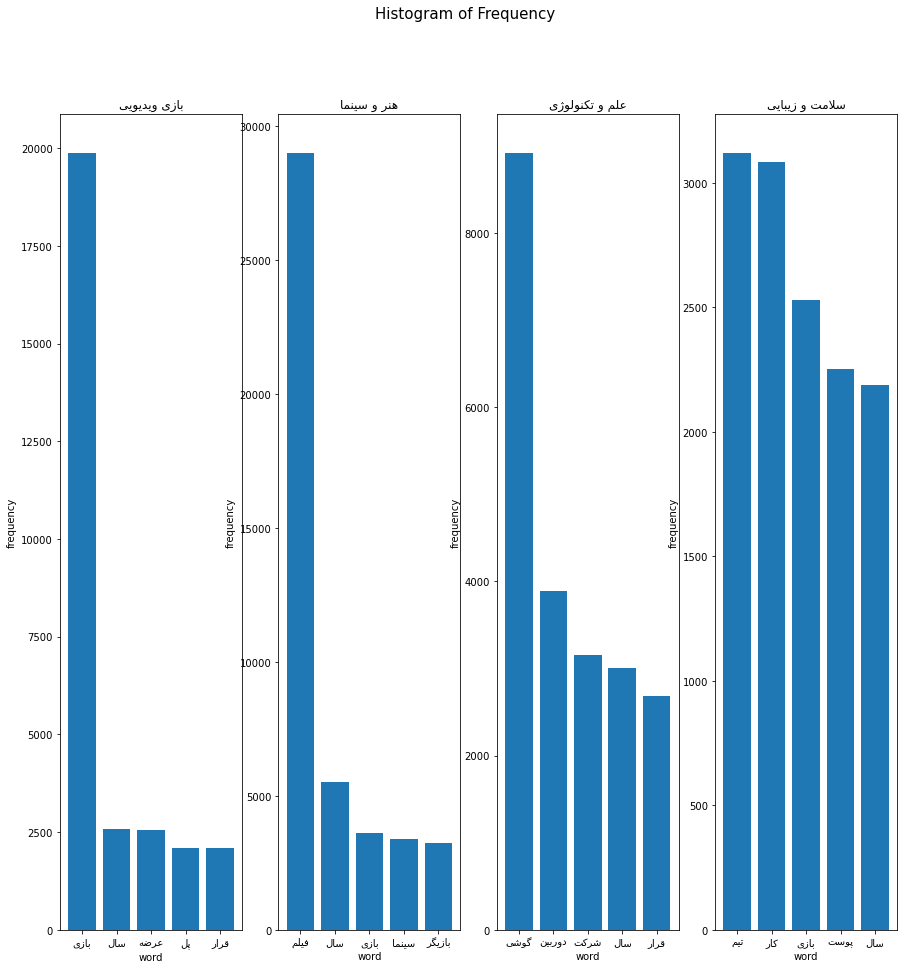

In [11]:
classifier = Classifier()

start = time.time()
classifier.initialize(train, test, PREPROCESS_AND_SMOOTH)
classifier.start()
end = time.time()
print(f'\nTime: {(end - start)} seconds')

## فاز سوم: ارزیابی
### سوال 7
Precision : وقتی‌که مدل، نتیجه را مثبت پیش‌بینی می‌کند، این نتیجه تا چه اندازه درست است؟ زمانیکه FP بالا باشد، معیار صحت معیار مناسبی است. فرض می‌شود مدلی برای تشخیص سرطان وجود دارد و این مدل Precision پایینی داشته باشد. نتیجه امر این است که این مدل بیماری بسیاری از افراد را به اشتباه سرطان تشخیص می‌دهد که نتیجه این امر استرس زیاد، آزمایش‌های فراوان و هزینه‌های گزاف برای بیمار خواهد بود. در این مدل، اگر معیار Recall بالا باشد بهتر است. در نقطه مقابل پارامتر Precision، معیار Recall می‌باشد و مواقعی که دقت کلاس منفی حائز اهمیت است یعنی FN مهم است معیار Recall استفاده خواهد شد. فرض شود مدلی برای تشخیص بیماری کشنده کرونا وجود دارد اگر این مدل Recall پایینی داشته باشد افراد زیادی که آلوده به این بیماری کشنده هستند را سالم در نظر می‌گیرد و این فاجعه است. در این حالت Recall از Precision بهتر عمل می‌کند. 

### سوال 8
F1-score از میانگین هارمونی Precision و Recall استفاده می‌نماید. این میانگین‌گیری موجب می‌شود که بتوان به ترکیب مقادیر Precision و Recall برای ارزیابی مناسب اعتماد کرد.مشابه میانگین حسابی، F1-score همیشه جایی بین دقت و یادآوری خواهد بود. اما رفتار متفاوتی دارد F1-score به اعداد کمتر وزن بیشتری می دهد به عنوان مثال، زمانی که دقت 100٪ و Recall برابر 0% باشد،  F1-score برابر 0٪ خواهد بود و نه 50٪.

### سوال 9
در حالت macro مقادیر متمایز بدست آمده برای هر کلاس برای یک داده (که می‌تواند Precision و Recall یا F1 باشد) با یکدیگر جمع و بر تعداد کل کلاس‌ها تقسیم می‌شود.  
در حالت micro از رابطه TP/(TP+FP) استفاده می‌شود که TP برابر کل پیش‌بینی‌های درست و FP برابر کل پیش‌بینی‌های نادرست است و در نهایت TP+FP برابر همان تعداد کل داده‌ها است. این میانگین برابر با همان accuracy خواهد شد.  
در حالت weighted مقادیر متمایز بدست آمده برای هر کلاس برای یک داده (که می‌تواند Precision و Recall یا F1 باشد) در تعداد کل داده‌های آن کلاس ضرب و سپس با یکدیگر جمع می‌شود و در نهایت بر تعداد کل کلاس‌ها تقسیم خواهد شد.

### سوال 10
در ادامه دو حالتی که smooth فعال باشد و نباشد با هم مقایسه شده است همان طور که مشاهده می‌شود تاثیر فعال بودن smooth  خیلی به بهتر شدن نتیجه کمک می‌کند و دقت نسبتا خوبی در مقایسه با حالتی که فقط preprocess  فعال بوده به دست آمده است. 

In [12]:
start = time.time()
classifier.initialize(train, test, JUST_PREPROCESS)
classifier.start()
end = time.time()
print(f'\nTime: {(end - start)} seconds')


 ******  Preprocessing  ****** 
Accuracy: 51.25
Precision: 71.20
Recall: 50.63
F1_score:  50.56
+---------------+-------------+-----------------+----------------------+--------------+-------------+
| Preprocessing | Video games | Health & Beauty | Science & Technology | Art & Cinema | All classes |
+---------------+-------------+-----------------+----------------------+--------------+-------------+
|   Precision   |    34.01    |      65.08      |        93.60         |    92.11     |      -      |
|     Recall    |    92.89    |      25.47      |        42.24         |    41.92     |      -      |
|    F1-score   |    49.80    |      36.61      |        58.21         |    57.61     |      -      |
|    Accuracy   |      -      |        -        |          -           |      -       |    51.25    |
|   Macro Avg   |      -      |        -        |          -           |      -       |    75.62    |
|   Micro Avg   |      -      |        -        |          -           |      -       |

In [17]:
index = classifier.index
mode = classifier.mode
classifier.index = 0
classifier.mode = 'Preprocessing & Smoothing'
classifier.draw_parameter_table()
classifier.index = index
classifier.mode = mode

+---------------------------+-------------+-----------------+----------------------+--------------+-------------+
| Preprocessing & Smoothing | Video games | Health & Beauty | Science & Technology | Art & Cinema | All classes |
+---------------------------+-------------+-----------------+----------------------+--------------+-------------+
|         Precision         |    95.51    |      87.79      |        93.88         |    91.95     |      -      |
|           Recall          |    86.29    |      93.79      |        94.22         |    95.81     |      -      |
|          F1-score         |    90.67    |      90.69      |        94.05         |    93.84     |      -      |
|          Accuracy         |      -      |        -        |          -           |      -       |    92.52    |
|         Macro Avg         |      -      |        -        |          -           |      -       |    96.26    |
|         Micro Avg         |      -      |        -        |          -           |    

### سوال 11
وقتی فقط preprocessing انجام می شود چون تعداد کلمات مقاله زیاد است احتمال اینکه در قاعده ضرب نتیجه صفر شود بیشتر است و خطا در این حالت نسبت به زمانی که smooth فعال می شود خیلی بیشتر است نتایجی که در حالت just smooth  بدست امده است هم از نتیجه just preprocess خیلی بهتر است.

In [13]:
start = time.time()
classifier.initialize(train, test, JUST_SMOOTH)
classifier.start()
end = time.time()
print(f'\nTime: {(end - start)} seconds')


 ******  Smoothing  ****** 
Accuracy: 77.31
Precision: 76.74
Recall: 77.58
F1_score:  76.73

Time: 5.4563376903533936 seconds


حالتی که نه preprocess و نه smooth فعال باشد نیز برای مقایسه تست شد و نتیجه در جدول زیر آمده‌است همان‌طور که انتظار می‌رفت این حالت دارای کمترین متریک می‌باشد.

In [18]:
start = time.time()
classifier.initialize(train, test, NOTHING)
classifier.start()
end = time.time()
print(f'\nTime: {(end - start)} seconds')


 ******  Nothing  ****** 
Accuracy: 38.53
Precision: 72.66
Recall: 37.74
F1_score:  32.34
+---------------------------+----------+-----------+--------+----------+
|   Classification Method   | Accuracy | Precision | Recall | F1_score |
+---------------------------+----------+-----------+--------+----------+
| Preprocessing & Smoothing |  92.52   |   92.28   | 92.53  |  92.31   |
|       Preprocessing       |  51.25   |   71.20   | 50.63  |  50.56   |
|         Smoothing         |  77.31   |   76.74   | 77.58  |  76.73   |
|          Nothing          |  38.53   |   72.66   | 37.74  |  32.34   |
+---------------------------+----------+-----------+--------+----------+

Time: 5.467846632003784 seconds


### سوال 12
تعداد کلمات مقاله زیاد می باشد بنابراین ماکزیمم از 75 کلمه در دیتا ست test برای prediction استفاده شده است که این امر می‌تواند موجب خطا شود از طرفی در مدل نیز ساده سازی صورت گرفته و در آن کلمات یک جمله مستقل از هم در نظر گرفته شده است که در واقعیت نمی توان کلمات یک جمله را نسبت به هم مستقل در نظر گرفت.
با این حال با کمک smooth و preprocess نتایج خوبی به دست آمده است.

In [21]:
classifier.store_wrongly_detected()
classifier.print_wrongly_samples()

1 -
Content: ['گوگل', 'استیدیا', 'آینده', 'صنعت', 'بازی', 'محکوم', 'شکست', 'ماه', 'خرده', 'گوگل', 'بلاخره', 'مدت', 'معرفی', 'تبلیغ', 'تیزر', 'سرویس', 'استیدیا', 'عرضه', 'عرضه', 'پلتفرم', 'ابری', 'شگفتی', 'فاجعه', 'بار', 'عرضه', 'تاریخ', 'صنعت', 'بازی', 'بدل', 'تعداد', 'اندک', 'کاربرانی', 'سرویس', 'استقبال', 'اپلیکیشن', 'استیدیا', 'دانلود', 'دانست&دان', 'تعداد', 'دانلود', 'کنجکاوی', 'برنامگی', 'گوگل', 'ارسال', 'کد', 'لازم', 'بزرگی', 'کسانیکه', 'سرویس', 'خرید', 'یکدست', 'نبودن', 'تجربه', 'کاربری', 'شهادت', 'توجه', 'کاربر', 'تاخیر', 'بازی', 'پلتفرم', 'ممکن', 'قیمت', 'گران', 'بازی', 'نسبت', 'پلتفرمها', 'کیفیت', 'پایین', 'تصویر', 'قیاس', 'کنسول', 'نسل', 'اجرا', 'بازی', 'رزولوشن', 'علی', 'رغم', 'وعده', 'گوگل', 'ادامه', 'انتشار', 'نسخه', 'قدیمی', 'رده', 'بوردرلندز', 'گوشه', 'افتضاح', 'تفاسیر', 'پلتفرم', 'امید', 'فراوان', 'بسته', 'آینده', 'صنعت', 'بازی', 'ادامه', 'نگاه', 'مفهوم', 'بازی', 'ابری', 'بررسی', 'پروژه', 'استیدیای', 'گوگل', 'صحت', 'سقم', 'ادعا', 'بررسی', 'بازی', 'ابری', 'پردازش', 'اطل